In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from fancyimpute import KNN
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_score, KFold,train_test_split
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
df_customer=pd.read_excel('customers.csv.xlsx', index_col=0)
df_trans=pd.read_excel('transactions.csv.xlsx')

In [4]:
df_PurValue=df_trans.groupby('customer_id')['transaction_value'].mean().reset_index().rename(columns={'transaction_value': 'average_purchase_value'})


In [5]:
df_NumPurch=df_trans.groupby('customer_id')['transaction_value'].count().reset_index().rename(columns={'transaction_value': 'number_of_purchases'})


In [6]:
df_LifeTime=df_trans.groupby('customer_id').agg({'transaction_date': lambda x: (x.max()-x.min())/np.timedelta64(1,'M')}).reset_index().rename(columns={'transaction_date': 'customer_lifetime'})


In [9]:
df_cltv=pd.concat([df_PurValue,df_NumPurch['number_of_purchases'],df_LifeTime['customer_lifetime']], axis=1)
df_cltv

,customer_id,average_purchase_value,number_of_purchases,customer_lifetime
0,0.0,27.300000,3,1.408036
1,1.0,32.644444,18,63.934589
2,2.0,26.022222,9,13.015211
3,3.0,22.916667,3,8.576450
4,4.0,27.448824,34,62.753485
...,...,...,...,...
63448,63448.0,27.560000,1,0.000000
63449,63449.0,11.660000,1,0.000000
63450,63450.0,11.610000,1,0.000000
63451,63451.0,27.820000,1,0.000000


In [10]:
df_cltv['customer_lifetime']=df_cltv['customer_lifetime'].replace(0,1)

In [11]:
df_cltv

,customer_id,average_purchase_value,number_of_purchases,customer_lifetime
0,0.0,27.300000,3,1.408036
1,1.0,32.644444,18,63.934589
2,2.0,26.022222,9,13.015211
3,3.0,22.916667,3,8.576450
4,4.0,27.448824,34,62.753485
...,...,...,...,...
63448,63448.0,27.560000,1,1.000000
63449,63449.0,11.660000,1,1.000000
63450,63450.0,11.610000,1,1.000000
63451,63451.0,27.820000,1,1.000000


In [12]:
df_cltv['cltv']=df_cltv['average_purchase_value']*df_cltv['number_of_purchases']/df_cltv['customer_lifetime']*6



len(df_cltv[df_cltv['customer_lifetime']==1])

17391

<AxesSubplot:>

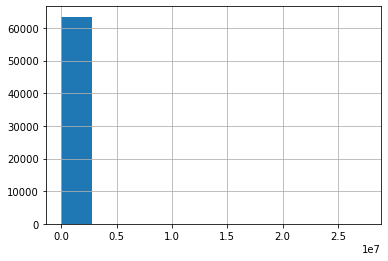

In [13]:
df_cltv['cltv'].hist()

In [14]:
df=df_customer.merge(df_cltv[['customer_id', 'cltv']], on='customer_id', how='right').dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46028 entries, 0 to 63452
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             46028 non-null  float64
 1   state                   46028 non-null  object 
 2   age                     46028 non-null  float64
 3   gender                  46028 non-null  object 
 4   income                  46028 non-null  float64
 5   is_married              46028 non-null  object 
 6   promo_group_1           46028 non-null  object 
 7   promo_group_2           46028 non-null  object 
 8   customer_loyalty_index  46028 non-null  float64
 9   brand_awareness_index   46028 non-null  float64
 10  cltv                    46028 non-null  float64
dtypes: float64(6), object(5)
memory usage: 4.2+ MB


In [15]:
cat=[]
cont=[]
for i in list(df.columns)[1:]:
    if df[i].dtype=='object':
        df[i]=df[i].apply(lambda x: str(x))
        cat.append(i)    
    else:
        if i=='cltv':
            pass
        else:
            cont.append(i)

In [16]:
cat_matrix = OneHotEncoder().fit_transform(df[cat]).toarray()
ohe=OneHotEncoder().fit(df[cat])
new_columns=[]
new_columns=ohe.get_feature_names(cat)
df_cat=pd.DataFrame(cat_matrix, columns=new_columns)
cont_matrix=StandardScaler().fit_transform(df[cont])
df_cont=pd.DataFrame(cont_matrix, columns=[cont])
df_combined = pd.concat([df_cont, df_cat], axis=1)

X=pd.DataFrame(df_combined, columns=df_combined.columns)
y=df['cltv'].values

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
cv = KFold(n_splits=5, shuffle=True, random_state=41)

dt=DecisionTreeRegressor()
rfr = RandomForestRegressor()
abr = AdaBoostRegressor()
gbst = GradientBoostingRegressor()

def score(model, name):
    s = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1,scoring='neg_mean_absolute_error')
    print ("{} Score:\t{:0.3} ± {:0.3}".format(name, abs(s.mean().round(5)), s.std().round(5)))

score(dt, "Decision Tree")
score(rfr, "Random Forest")
score(abr, "Ada Boost")
score(gbst, "Grad Boosting")


Decision Tree Score:	7.77e+03 ± 1.65e+03
Random Forest Score:	7.9e+03 ± 6.34e+02
Ada Boost Score:	3.2e+05 ± 2.18e+05
Grad Boosting Score:	7.34e+03 ± 9.48e+02



Feature Weights:


,Weight
"(customer_loyalty_index,)",0.804402
"(brand_awareness_index,)",0.091721
state_CA,0.024100
"(income,)",0.023597
state_NH,0.013559
promo_group_1_B,0.011386
"(age,)",0.010975
state_ME,0.008333
promo_group_2_X,0.007113
state_FL,0.001589


None


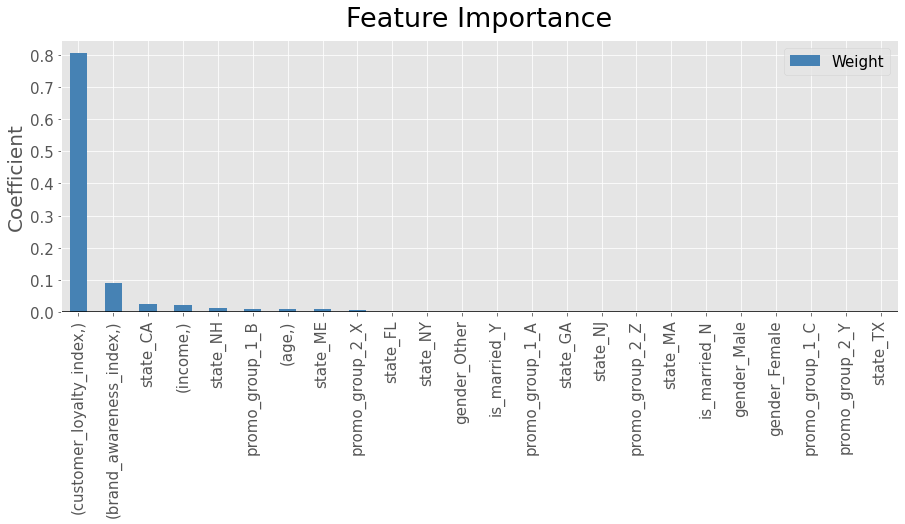

In [18]:
# plt.style.use('fivethirtyeight')
plt.style.use('ggplot')

gbst.fit(X_train, y_train)
importances = pd.DataFrame((gbst.feature_importances_),
                           index=X_train.columns,
                           columns=['Gradient Boosting']).sort_values('Gradient Boosting',
                                                                 ascending=False).rename(columns={'index': 'Feature', 'Gradient Boosting': 'Weight'})

print ()
print ('\033[1m'+'Feature Weights:'+'\033[0m')
print (display(importances.head(30)))



importances.plot(kind='bar', figsize=(15,5), color='steelblue')
plt.title('Feature Importance', fontsize = 27, y = 1.03, color='black')
plt.ylabel('Coefficient', fontsize = 20)
plt.yticks(fontsize = 15)
plt.axhline(0, color='black')
plt.xticks(rotation=90, fontsize = 15)

plt.legend(fontsize = 15)
plt.show()